In [59]:
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime

%matplotlib inline  

df = quandl.get("WIKI/GOOGL")
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

# We're saying we want to forecast out 1% of the entire length of the dataset. 
# Thus, if our data is 100 days of stock prices, we want to be able to predict 
# the price 1 day out into the future. Choose whatever you like. If you are just 
# trying to predict tomorrow's price, then you would just do 1 day out, and the 
# forecast would be just one day out. If you predict 10 days out, we can actually 
# generate a forcast for every day, for the next week and a half.
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['label'])


In [60]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

for k in ['linear','poly','rbf','sigmoid']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print(k,confidence)
    


linear 0.9755987122311569
poly 0.6122860904626185
rbf 0.8218210974795157
sigmoid 0.9008506274636741


In [61]:
clf = svm.SVR(kernel='linear')
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print('linear', confidence)
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan


linear 0.9755987122311569


In [62]:
df.tail()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label,Forecast
Date,,,,,,
2018-01-30,1177.37,1.139829,-0.029718,1792602.0,1094.00,NaN
2018-01-31,1182.22,1.202822,-0.134312,1643877.0,1053.15,NaN
2018-02-01,1181.59,1.530988,0.476195,2774967.0,1026.55,NaN
2018-02-02,1119.20,1.798606,-0.729098,5798880.0,1054.09,NaN
2018-02-05,1068.76,5.450241,-2.893850,3742469.0,1006.94,NaN


In [63]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
    
df.tail()


,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label,Forecast
Date,,,,,,
2018-03-07 18:00:00,NaN,NaN,NaN,NaN,NaN,1083.560615
2018-03-08 18:00:00,NaN,NaN,NaN,NaN,NaN,1041.829425
2018-03-09 18:00:00,NaN,NaN,NaN,NaN,NaN,1016.090224
2018-03-10 18:00:00,NaN,NaN,NaN,NaN,NaN,1042.192191
2018-03-11 19:00:00,NaN,NaN,NaN,NaN,NaN,994.472689


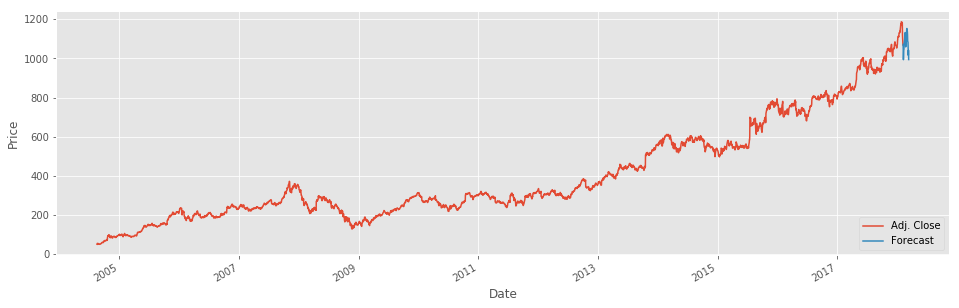

In [64]:
plt.figure(figsize=(16,5))
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()